# **1-Introduction**

The point of this script is to train both XGBoost and RandomForest models to detect anomaly traffic using an already preprocessed dataset.
Even though the Dataset went through the preprocessing process it didn't go through nor scaling nor sampling.

# **2-Importing necessary libraries**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import joblib

# **3-Loading dataset**

here we're loading the already preprocessed datasets to inspect,manage and then feed them to the models

In [4]:
train_path = 'Dataset/kdd_train.csv'
test_path  = 'Dataset/kdd_test.csv'
train_data = pd.read_csv(train_path)
test_data  = pd.read_csv(test_path)

# **4- Inspecting data**

to understand the datasets more we need to inspect them and see it through and through

In [3]:
print("Training data shape : ",train_data.shape)
print("Testing data shape : ",test_data.shape)
print('Columns : ')
print(train_data.dtypes)
print('attack types in the training dataset')
print(train_data['labels'].value_counts(dropna=False))
print('attack types in the testing dataset')
print(test_data['labels'].value_counts(dropna=False))
series=train_data['service'].value_counts(dropna=False)
for i in series.index:
    print(f"{i}: {series[i]}")
print(train_data['protocol_type'].value_counts(dropna=False), "\n")
train_data.head()


Training data shape :  (125973, 42)
Testing data shape :  (22544, 42)
Columns : 
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count             

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# **5- Preparing data for the models**
Before training the model we need to define our target and split the data since RandomForest is a supervised algorithm which mean it need to know the answers during training

In [5]:
# Separating the input and the output
FEATURES = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "count",
    "srv_count",
    "same_srv_rate",
    "diff_srv_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate"
]
X_train = train_data[FEATURES]
y_train = train_data['labels']
X_test  = test_data[FEATURES]
y_test  = test_data['labels']

# Map Labels to new categories
attack_map = {
    'normal': 0,
    'back':1,'land':1,'neptune':1,'pod':1,'smurf':1,'teardrop':1,
    'ipsweep':1,'nmap':1,'portsweep':1,'satan':1,
    'ftp_write':1,'guess_passwd':1,'imap':1,'multihop':1,'phf':1,
    'spy':1,'warezclient':1,'warezmaster':1,
    'buffer_overflow':1,'loadmodule':1,'perl':1,'rootkit':1,'sqlattack':1,'xterm':1
}
y_train = y_train.map(attack_map)
y_test  = y_test.map(attack_map)
mask = y_test.notna()
X_test = X_test[mask]
y_test = y_test[mask]
# Identifying Categorical and Numerical features
cat_cols = ["protocol_type", "service", "flag"]
num_cols = [c for c in FEATURES if c not in cat_cols]
# Encoding Categorical features and Scaling Numerical features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# Using SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)



"\n# Selecting Top features \nmi = mutual_info_classif(X_train_res, y_train_res)\ntop_k = 30\nselected_features = np.argsort(mi)[-top_k:]\n\nX_train_sel = X_train_res.iloc[:, selected_features]\nX_test_sel  = X_test.iloc[:, selected_features]\n# NDAE: Nonlinear Denoising Autoencoder\ndef NDAE_model(input_dim, latent_dim=16, dropout_rate=0.2, noise_std=0.2):\n    inputs = Input(shape=(input_dim,))\n    x = GaussianNoise(noise_std)(inputs)\n    x = Dense(64, activation='relu')(x)\n    x = Dropout(dropout_rate)(x)\n    latent = Dense(latent_dim, activation='relu')(x)\n    x = Dense(64, activation='relu')(latent)\n    outputs = Dense(input_dim, activation='linear')(x)\n    model = Model(inputs, outputs)\n    encoder = Model(inputs, latent)\n    return model, encoder\n\nndae, encoder = NDAE_model(input_dim=X_train_sel.shape[1])\nndae.compile(optimizer='adam', loss='mse')\nndae.fit(X_train_sel, X_train_sel, epochs=20, batch_size=256, validation_split=0.1)\n\n# Latent representation + reconst

# **6-1 Training RandomForest Classifier model**
since the data is ready now we can train our model

In [6]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**6-2 Training XGBoost Classifier**
and now for the XGBoost model

In [16]:
xgboost = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgboost.fit(X_train_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# **7 -Evaluating Random forest model**
# 7-1 Accuracy and confusion matrix

              precision    recall  f1-score   support

      Normal       0.94      0.99      0.97     11245
      Attack       0.99      0.94      0.96     10156

    accuracy                           0.97     21401
   macro avg       0.97      0.96      0.96     21401
weighted avg       0.97      0.97      0.97     21401



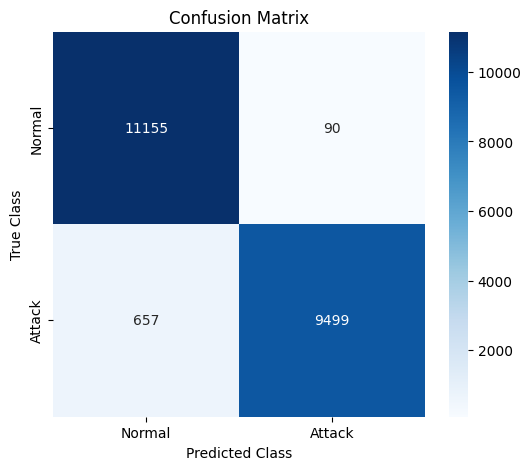

In [11]:
y_pred = rf.predict(X_test_enc)
print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# 7-2 Importance and Accuracy result for each label

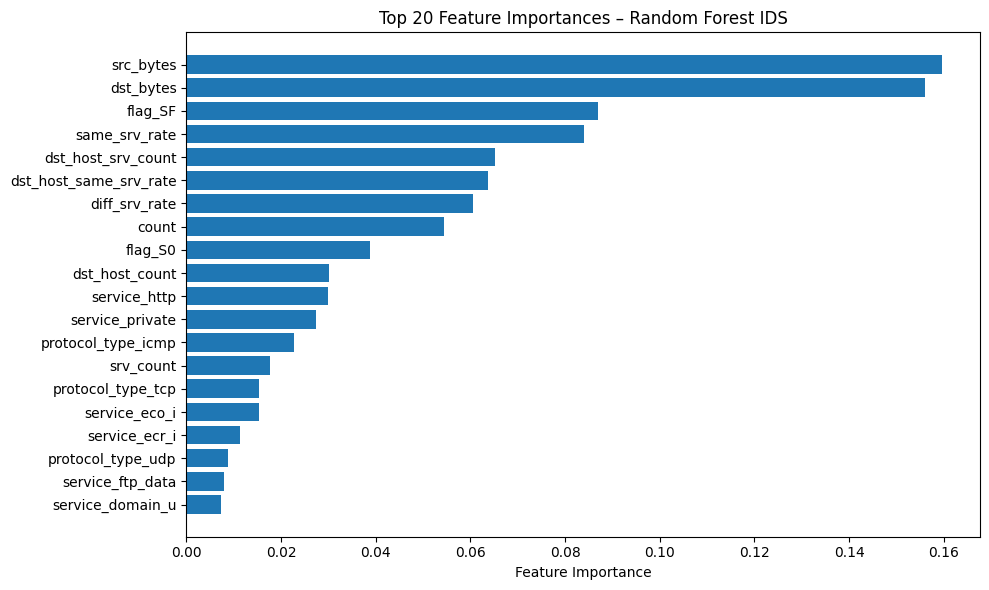

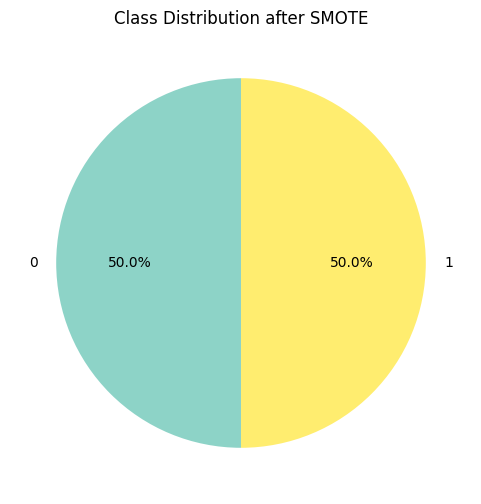

In [17]:
# Get feature names
num_features = num_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_features, cat_features])
importances = rf.feature_importances_
# Sort by importance
indices = np.argsort(importances)[::-1]
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(
    range(top_n),
    importances[indices[:top_n]][::-1]
)

plt.yticks(
    range(top_n),
    feature_names[indices[:top_n]][::-1]
)

plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances – Random Forest IDS")
plt.tight_layout()
plt.show()

# Pie Chart of Class Distribution
plt.figure(figsize=(6,6))
y_train_res.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title("Class Distribution after SMOTE")
plt.ylabel("")
plt.show()

# **8 -Evaluating XGBoost model**
# 8-1 Accuracy and confusion matrix

              precision    recall  f1-score   support

      Normal       0.94      0.99      0.97     11245
      Attack       0.99      0.94      0.96     10156

    accuracy                           0.97     21401
   macro avg       0.97      0.96      0.96     21401
weighted avg       0.97      0.97      0.96     21401



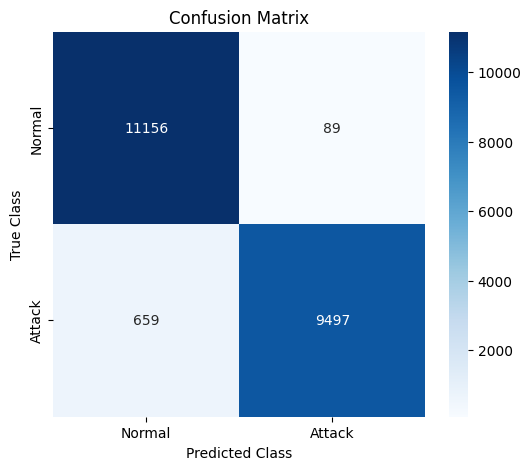

In [18]:
xgb_y_pred = xgboost.predict(X_test_enc)
print(classification_report(y_test, xgb_y_pred, target_names=["Normal", "Attack"]))

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# 8-2 Importance and Accuracy result for each label

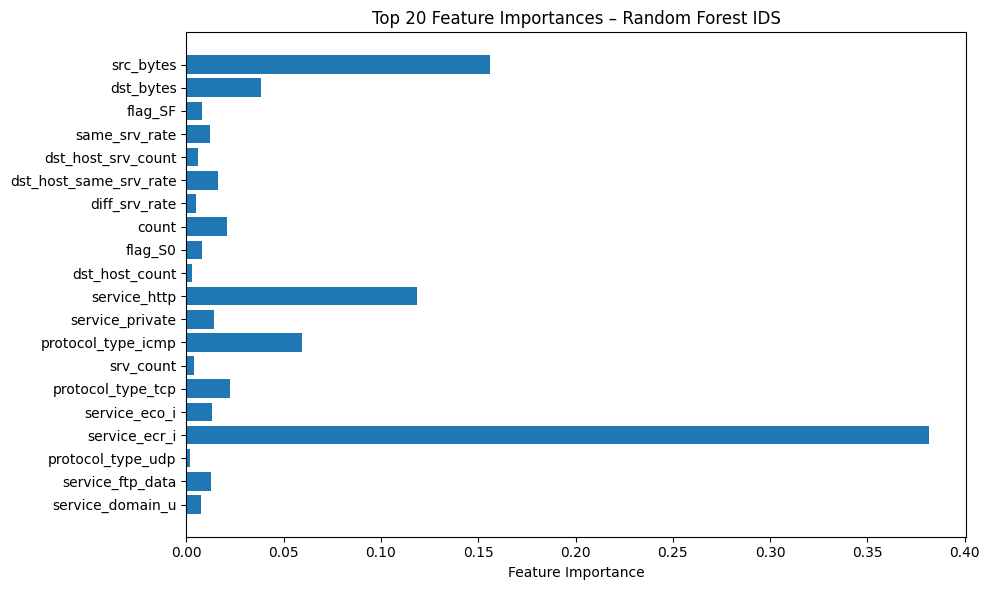

In [19]:
importances = xgboost.feature_importances_
# Sort by importance
plt.figure(figsize=(10, 6))
plt.barh(
    range(top_n),
    importances[indices[:top_n]][::-1]
)

plt.yticks(
    range(top_n),
    feature_names[indices[:top_n]][::-1]
)

plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances – Random Forest IDS")
plt.tight_layout()
plt.show()

# **9- Exporting Model**

In [20]:
# Saving the RandomForest and pipeline
pipelineRF = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", rf)
])
joblib.dump(pipelineRF, './model/RF_Pipeline.pkl')
pipelineRF.fit(X_train, y_train)
print("Pipeline saved successfully to 'RF_Pipeline.pkl'")

# Saving the XGBoost and pipeline
pipelineXGBoost = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", xgboost)
])
joblib.dump(pipelineXGBoost, './model/XGBoost_Pipeline.pkl')
pipelineXGBoost.fit(X_train, y_train)
print("Pipeline saved successfully to 'XGBoost_Pipeline.pkl'")

Pipeline saved successfully to 'RF_Pipeline.pkl'
Pipeline saved successfully to 'XGBoost_Pipeline.pkl'
